# Simulate PD Response

This code models a photodetector response as a low pass filter. It applies that filter to the time domain signal of a laser sweeping through a resonance.

## Helper functions

In [1]:
from scipy.optimize import curve_fit
import numpy as np

c = 299792458
conversion = lambda pos, band: abs( c * band / ( pos ** 2 - ( band / 2 ) ** 2 ) )

def lorentzian(freq, freq_0, gamma, m):
    '''
    T = 1 - m G^2 / ( G^2 + (freq - freq_0) ^2 )
    |alpha| = |G|
    theta = G +- G sqrt( 1 - m )
    '''
    return 1 - m * gamma ** 2 / ( gamma ** 2 + (freq - freq_0) ** 2 )

def find_Q(frequency, transmission, fwhm_guess):
    f0_guess = frequency[np.argmin(transmission)]
    
    fit, pcov = curve_fit(lorentzian, frequency, transmission, [f0_guess, fwhm_guess / 2, 1])
    
    f0, gamma, m = fit
    alpha = gamma
    if m > 1 and ( m - 1 ) < 0.01:
        theta = gamma
        alpha_i = gamma
    else:
        theta = gamma + gamma * np.sqrt( 1 - m )
        alpha_i = gamma - gamma * np.sqrt( 1 - m )

    results = {
        'Q_int': f0 / alpha_i,
        'Q_ext': f0 / theta,
        'Q': f0 / ( alpha_i + theta ),
        'fit': fit
    }
    
    return results

## Make input signal

Using

$$\begin{align}
L(f) &= 1 - \frac{\Gamma^2}{\Gamma^2 + (f - f_0)^2}
\end{align}$$

Where the FWHM = $2 \Gamma$

[useful thorlabs article](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=9817)

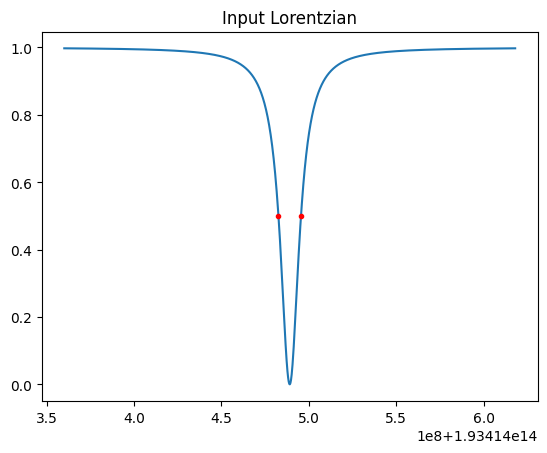

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Q = 15e6
wl0 = 1550e-9
laser_speed = 20e-9
f_3dB = 0.1e6

f0 = c / wl0
fwhm = f0 / Q
gamma = fwhm / 2

wl = np.linspace(wl0 - 10 * conversion(f0, fwhm), wl0 + 10 * conversion(f0, fwhm), 10000)
f_optical = c / wl
# input_signal = gamma ** 2 / (gamma ** 2 + ( f_optical - f0 ) ** 2)
# input_signal = np.abs( 1 - ( gamma ) / ( gamma + 1j * (f_optical - f0)) ) ** 2
input_signal = 1 - gamma ** 2 / ( gamma ** 2 + (f_optical - f0) ** 2)

plt.plot(f_optical, input_signal)
plt.plot([f0 + fwhm / 2, f0 - fwhm / 2], [1/2, 1/2], 'r.')
plt.title('Input Lorentzian')
plt.show()

## Apply Transfer function

Translate wavelength -> time, FFT, apply low pass filter, iFFT

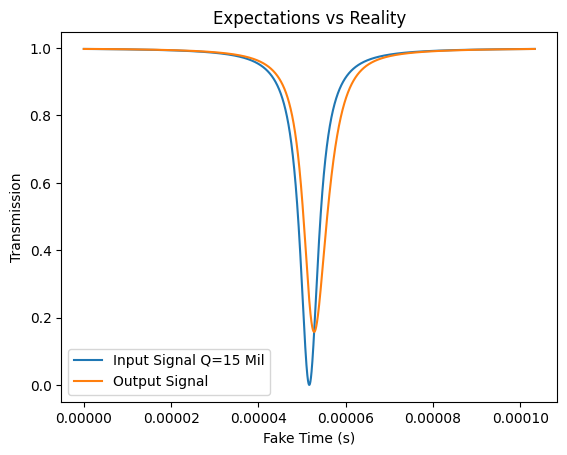

In [3]:
t = ( wl - wl[0] ) / laser_speed
t_step = abs(np.mean(np.diff(t)))
input_signal_f = np.fft.fft(input_signal)
freq = np.fft.fftfreq(len(input_signal), t_step)

RC = 1 / (2 * np.pi * f_3dB)

lowpass_transfer = 1 / ( 2j * np.pi * freq * RC + 1 )

output_signal_f = lowpass_transfer * input_signal_f
output_signal = np.abs( np.fft.ifft(output_signal_f) )
# plt.title('FFT')
# plt.plot(freq, np.abs(input_signal_f))
# plt.show()

plt.plot(t, input_signal, label=f'Input Signal Q={Q/1e6:.0f} Mil')
plt.plot(t, output_signal, label='Output Signal')

plt.xlabel('Fake Time (s)')
plt.ylabel('Transmission')
plt.title('Expectations vs Reality')
plt.legend()
plt.show()

## With Q Fitting

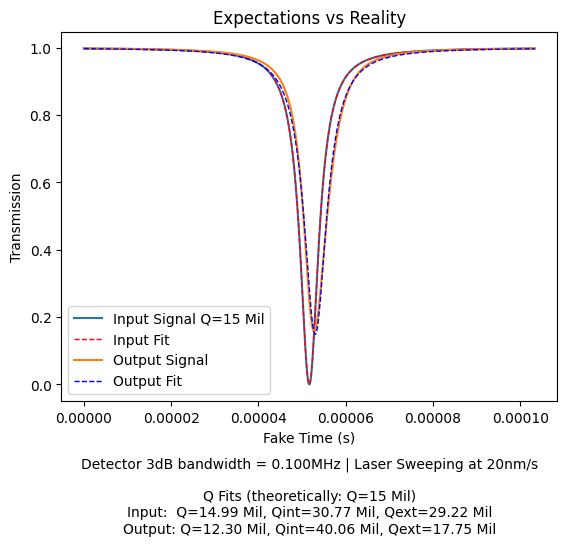

In [4]:
plt.plot(t, input_signal, label=f'Input Signal Q={Q/1e6:.0f} Mil')
in_res = find_Q(f_optical, input_signal, fwhm)
plt.plot(t, lorentzian(f_optical, *in_res['fit']), 'r--', linewidth=1, label='Input Fit')

plt.plot(t, output_signal, label='Output Signal')
out_res = find_Q(f_optical, output_signal, fwhm)
plt.plot(t, lorentzian(f_optical, *out_res['fit']), 'b--', linewidth=1, label='Output Fit')

plt.xlabel('Fake Time (s)')
plt.ylabel('Transmission')
plt.title('Expectations vs Reality')
plt.text(0.5, -0.15, 
f'''Detector 3dB bandwidth = {f_3dB/1e6:.3f}MHz | Laser Sweeping at {laser_speed*1e9:.0f}nm/s

Q Fits (theoretically: Q={Q/1e6:.0f} Mil)
Input:  Q={in_res['Q']/1e6:.2f} Mil, Qint={in_res['Q_int']/1e6:.2f} Mil, Qext={in_res['Q_ext']/1e6:.2f} Mil
Output: Q={out_res['Q']/1e6:.2f} Mil, Qint={out_res['Q_int']/1e6:.2f} Mil, Qext={out_res['Q_ext']/1e6:.2f} Mil''', 
         ha='center', va='top', transform=plt.gca().transAxes)
plt.legend()
plt.show()